In [1]:
import math 
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import os; 
print(os.getcwd())
import cvxpy as cp
from multiprocessing import Pool
from joblib import Parallel, delayed

c:\Users\TGY\MIT Dropbox\Wallace Yion\Research\Braatz\Fourth Paper\Submission Code


In [2]:
def _box_tensors(box, dtype, device):
    box = torch.as_tensor(box, dtype=dtype, device=device)  # shape (2,2): [[xmin,xmax],[ymin,ymax]]
    xmin, xmax = box[:,0], box[:,1]
    alpha = 0.5*(xmax - xmin)          # scale
    beta  = 0.5*(xmax + xmin)          # offset
    return xmin, xmax, alpha, beta

def to_box_scaled(X, box):
    """Map raw X (N,2) to U in [-1,1]^2 for an arbitrary box."""
    xmin, xmax, alpha, beta = _box_tensors(box, X.dtype, X.device)
    return (X - beta) / (alpha + 1e-12)

def from_box_scaled(U, box):
    """Inverse: map U in [-1,1]^2 back to raw X."""
    xmin, xmax, alpha, beta = _box_tensors(box, U.dtype, U.device)
    return alpha*U + beta

# ---------- 1D Legendre (orthonormal on [-1,1]) ----------
def legendre1d_orthonorm(x, deg):
    """
    φ_n(x) = sqrt((2n+1)/2) * P_n(x), with P_0=1, P_1=x, P_{n+1} = ((2n+1)xP_n - nP_{n-1})/(n+1)
    x: (N,) in [-1,1]. Returns Phi: (N, deg+1).
    """
    x = x.reshape(-1, 1)
    N = x.shape[0]
    Phi = torch.zeros((N, deg+1), dtype=x.dtype, device=x.device)
    Phi[:, 0] = math.sqrt(0.5)
    if deg == 0: return Phi
    Phi[:, 1] = math.sqrt(1.5) * x.squeeze(1)
    P0 = torch.ones_like(x)     # P_0
    P1 = x.clone()              # P_1
    for n in range(1, deg):
        P2 = ((2*n+1)*x*P1 - n*P0) / (n+1)    # P_{n+1}
        Phi[:, n+1] = math.sqrt((2*n+3)/2.0) * P2.squeeze(1)
        P0, P1 = P1, P2
    return Phi

# ---------- 2D tensor-product Legendre dictionary on an arbitrary box ----------
def legendre2d_phi_box(X, box, deg, include_bias=True, total_degree=True , verbose = False):
    """
    X:   (N,2) raw states (any rectangle)
    box: [[xmin,xmax],[ymin,ymax]]
    deg: max polynomial degree
    include_bias: prepend constant 1 column
    total_degree: keep (i,j) with i+j<=deg (True) or full grid (False)

    Returns:
      Z:         (N,p) dictionary built on scaled coords U∈[-1,1]^2
      Csel_u:    (2,p) linear decoder to recover U from Z
      Csel_x:    (2,p) linear decoder to recover raw X from Z (uses bias for offset)
      pairs:     list of (i,j) for each non-bias column in Z
    """
    assert X.shape[1] == 2
    # scale to unit box
    U = to_box_scaled(X, box)                 # (N,2) in [-1,1]^2
    x, y = U[:,0], U[:,1]

    Phi_x = legendre1d_orthonorm(x, deg)      # (N,deg+1)
    Phi_y = legendre1d_orthonorm(y, deg)

    cols, pairs = [], []
    if include_bias:
        cols.append(torch.ones((X.shape[0],1), dtype=X.dtype, device=X.device))

    for i in range(deg+1):
        for j in range(deg+1):
            if i == 0 and j == 0:
                continue  # bias already added
            if total_degree and (i+j > deg):
                continue
            cols.append(Phi_x[:, i:i+1] * Phi_y[:, j:j+1])  # φ_i(x)*φ_j(y)
            pairs.append((i,j))

    Z = torch.cat(cols, dim=1)                # (N,p)

    # decoder to U uses columns (1,0) and (0,1):
    # φ1(x)φ0(y) = (sqrt(3)/2)*x, φ0(x)φ1(y) = (sqrt(3)/2)*y
    s = math.sqrt(3.0) / 2.0
    off = 1 if include_bias else 0
    try:
        idx10 = pairs.index((1,0)) + off
        idx01 = pairs.index((0,1)) + off
    except ValueError:
        raise RuntimeError("Dictionary lacks linear terms (1,0) and/or (0,1). Use deg>=1.")

    Csel_u = torch.zeros((2, Z.shape[1]), dtype=X.dtype, device=X.device)
    Csel_u[0, idx10] = 1.0 / s
    Csel_u[1, idx01] = 1.0 / s

    # decoder to raw X: x = alpha*u + beta (element-wise)
    _, _, alpha, beta = _box_tensors(box, X.dtype, X.device)  # shape (2,)
    Csel_x = alpha.unsqueeze(1) * Csel_u                       # scale the U rows
    if include_bias:
        Csel_x[:, 0] += beta                                   # add offsets via bias colum
    
    if verbose:
        return Z, Csel_u, Csel_x, U, pairs
    return Z


def decode_legendre2d(Z, pairs, box, include_bias=True):
    """
    Recover U (scaled coords) and X (original coords) from the dictionary Z
    built by your legendre2d_phi_box(...).

    Args:
      Z:   (N,p) feature matrix
      pairs: list of (i,j) for the non-bias columns (exactly as returned)
      box: [[xmin,xmax],[ymin,ymax]]
      include_bias: True if Z's first column is the bias 1

    Returns:
      U_hat: (N,2) in [-1,1]^2
      X_hat: (N,2) in original coordinates
    """
    # indices of linear terms
    off = 1 if include_bias else 0
    try:
        idx10 = pairs.index((1,0)) + off
        idx01 = pairs.index((0,1)) + off
    except ValueError:
        raise RuntimeError("Need linear terms (1,0) and (0,1); use deg >= 1.")

    # With your orthonormalization: φ1(x)=√(3/2) x, φ0(y)=√(1/2),
    # so φ1(x)φ0(y) = (√3/2) x, same for y.
    s = math.sqrt(3.0) / 2.0

    dtype, device = Z.dtype, Z.device
    U_hat = torch.empty((Z.shape[0], 2), dtype=dtype, device=device)
    U_hat[:, 0] = Z[:, idx10] / s
    U_hat[:, 1] = Z[:, idx01] / s

    # Rescale to raw coordinates: x = alpha * u + beta (per axis)
    xmin, xmax = box[0]
    ymin, ymax = box[1]
    alpha = torch.tensor([(xmax - xmin)/2.0, (ymax - ymin)/2.0], dtype=dtype, device=device)
    beta  = torch.tensor([(xmax + xmin)/2.0, (ymax + ymin)/2.0], dtype=dtype, device=device)

    X_hat = U_hat * alpha + beta
    return U_hat, X_hat

In [3]:
import numpy as np

# -------------------- Config --------------------
SEED = 7
rng  = np.random.default_rng(SEED)

# Duffing parameters (nonlinear but not chaotic; control-affine)
delta = 0.2     # damping
alpha = -1.0    # linear stiffness (negative -> double-well)
beta  = 1.0     # cubic stiffness

Ts      = 0.025
T_steps = 51
N_traj  = 2000

# Input (PRBS-like)
U_AMP    = 1
MIN_HOLD = 10
MAX_HOLD = 40

SAVE_PATH = "duffing_multistep.npz"

# --------------- Duffing + RK4 ---------------
def duffing_rhs(x, u, delta, alpha, beta):
    """
    Controlled Duffing oscillator:
        x1' = x2
        x2' = -delta*x2 - alpha*x1 - beta*x1^3 + u
    where x = [x1, x2] = [position, velocity]
    """
    x1, x2 = x
    dx1 = x2
    dx2 = -delta * x2 - alpha * x1 - beta * (x1**3) + u
    return np.array([dx1, dx2], dtype=np.float64)

def rk4_step(x, u, dt, delta, alpha, beta):
    k1 = duffing_rhs(x, u, delta, alpha, beta)
    k2 = duffing_rhs(x + 0.5*dt*k1, u, delta, alpha, beta)
    k3 = duffing_rhs(x + 0.5*dt*k2, u, delta, alpha, beta)
    k4 = duffing_rhs(x + dt*k3, u, delta, alpha, beta)
    return x + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

def make_prbs_sequence(T, amp, rng, min_hold=10, max_hold=40):
    """Piecewise-constant ±amp with random dwell lengths (in steps)."""
    seq = np.empty(T, dtype=np.float64)
    t = 0
    while t < T:
        hold = int(rng.integers(min_hold, max_hold + 1))
        val = amp if rng.random() < 0.5 else -amp
        seq[t:t+hold] = val
        t += hold
    return seq[:T]

# --------------- Dataset generation ---------------
def generate_dataset(N_traj, T_steps, Ts, rng):
    n, m = 2, 1
    Xs, Ys, Us = [], [], []

    for _ in range(N_traj):
        # IC box (same as your VdP)
        x = rng.uniform(-2.0, 2.0, size=(2,)).astype(np.float64)

        # Input sequence
        u_seq = make_prbs_sequence(T_steps, U_AMP, rng, MIN_HOLD, MAX_HOLD)

        # Simulate
        X_traj = np.empty((n, T_steps), dtype=np.float64)
        for k in range(T_steps):
            X_traj[:, k] = x
            x = rk4_step(x, u_seq[k], Ts, delta, alpha, beta)

        # Snapshots
        Xs.append(X_traj[:, :-1])          # x_k
        Ys.append(X_traj[:, 1:])           # x_{k+1}
        Us.append(u_seq[:-1][None, :])     # u_k

    X = np.stack(Xs, axis=0)  # (N_traj, 2, T_steps-1)
    Y = np.stack(Ys, axis=0)  # (N_traj, 2, T_steps-1)
    U = np.stack(Us, axis=0)  # (N_traj, 1, T_steps-1)
    return X, Y, U

In [4]:
if __name__ == "__main__":
    # Generate dataset
    X, Y, U = generate_dataset(N_traj, T_steps, Ts, rng)
    print("Generated dataset:")
    print("  X shape:", X.shape)
    print("  Y shape:", Y.shape)
    print("  U shape:", U.shape)

    # Save to .npz
    np.savez_compressed(SAVE_PATH, X=X, Y=Y, U=U, Ts=Ts, delta=delta, alpha=alpha, beta=beta)
    print(f"Dataset saved to {SAVE_PATH}")

Generated dataset:
  X shape: (2000, 2, 50)
  Y shape: (2000, 2, 50)
  U shape: (2000, 1, 50)
Dataset saved to duffing_multistep.npz


In [5]:
# ---- load or create your data as numpy arrays (columns = samples) ----
# X: (n, N), Y: (n, N), U: (m, N), THETA: (N,)
# For demo, we'll create placeholders; replace these with your data.
n, m = X.shape[1], U.shape[1]
# ---------- build features (ψ) ----------


X_init = torch.tensor(X[:, :, 0])
Yt = torch.tensor(Y)

# X,Y are torch tensors of shape (N,2) in *raw* units
box = [[-2.0, 2.0], [-2.0, 2.0]]   # <-- your rectangle (can be symmetric [-L,L],[-L,L] too)
deg_poly = 14
Z, Csel_u, Csel_x, _, pairs = legendre2d_phi_box(X_init, box, deg_poly, include_bias=True, total_degree=True, verbose=True)                       # (N, p)
# ---- feature-wise standardization (learn from Z; use train split if you have one) ----

print(Z.shape)
print(Yt.shape)
p  = Z.shape[1]

# decode matrix: first n features are the raw x (by construction)
Csel = torch.zeros((n, p)); Csel[:, :n] = torch.eye(n)



torch.Size([2000, 120])
torch.Size([2000, 2, 50])


In [6]:
def solve_row(G, Hk, y, beta=0.0, tau=0.0):
    """
    Solve min || G Ei_k + Hk Fi_k - y ||^2
            + beta ( ||[Ei_k; Fi_k]||_2^2 + tau ||Ei_k||_1 )
    """
    # G: (M,p), Hk: (M,k*m), y: (M,)
    # returns Ei_k: (p,), Fi_k: (k*m,), status
    Phi = np.concatenate([G, Hk], axis=1)   # (M, p + k*m)
    p = G.shape[1]                          # size of Ei_k
    d = Phi.shape[1]                        # p + k*m

    w = cp.Variable(d)      # stack [Ei_k; Fi_k]
    Ei = w[:p]              # first p entries
    Fi = w[p:]              # rest

    loss = cp.sum_squares(Phi @ w - y)  # fit term
    reg  = beta * (cp.sum_squares(w) + tau * cp.norm1(Ei))
    prob = cp.Problem(cp.Minimize(loss + reg))
    prob.solve(
    solver=cp.OSQP,
    verbose=False,
    eps_abs=1e-8,
    eps_rel=1e-8,
    max_iter=200000,
    polish=True,
    adaptive_rho=True
        )       

    return w.value[:p], w.value[p:], prob.status


In [7]:
n_x = Y.shape[1]
H = Y.shape[2]
E_array = []
F_array = []
statuses_array = []
G = Z.numpy()
for k in range(H):
    n_jobs = -1
    Hk = U[:,:,0:k+1].reshape(U[:,:,0:k+1].shape[0], -1)  # shape (2,12)
    results = Parallel(n_jobs=n_jobs)(
            delayed(solve_row)(G, Hk, Y[:, i, k])
            for i in range(n_x)
        )
    E_k = np.vstack([res[0] for res in results])   # (n_x, p)
    F_k = np.vstack([res[1] for res in results])   # (n_x, k*m)
    statuses = [res[2] for res in results]
    E_array.append(E_k)
    F_array.append(F_k)
    statuses_array.append(statuses)
    print(E_k.shape)
    print(F_k.shape)



(2, 120)
(2, 1)
(2, 120)
(2, 2)
(2, 120)
(2, 3)
(2, 120)
(2, 4)
(2, 120)
(2, 5)
(2, 120)
(2, 6)
(2, 120)
(2, 7)
(2, 120)
(2, 8)
(2, 120)
(2, 9)
(2, 120)
(2, 10)
(2, 120)
(2, 11)
(2, 120)
(2, 12)
(2, 120)
(2, 13)
(2, 120)
(2, 14)
(2, 120)
(2, 15)
(2, 120)
(2, 16)
(2, 120)
(2, 17)
(2, 120)
(2, 18)
(2, 120)
(2, 19)
(2, 120)
(2, 20)
(2, 120)
(2, 21)
(2, 120)
(2, 22)
(2, 120)
(2, 23)
(2, 120)
(2, 24)
(2, 120)
(2, 25)
(2, 120)
(2, 26)
(2, 120)
(2, 27)
(2, 120)
(2, 28)
(2, 120)
(2, 29)
(2, 120)
(2, 30)
(2, 120)
(2, 31)
(2, 120)
(2, 32)
(2, 120)
(2, 33)
(2, 120)
(2, 34)
(2, 120)
(2, 35)
(2, 120)
(2, 36)
(2, 120)
(2, 37)
(2, 120)
(2, 38)
(2, 120)
(2, 39)
(2, 120)
(2, 40)
(2, 120)
(2, 41)
(2, 120)
(2, 42)
(2, 120)
(2, 43)
(2, 120)
(2, 44)
(2, 120)
(2, 45)
(2, 120)
(2, 46)
(2, 120)
(2, 47)
(2, 120)
(2, 48)
(2, 120)
(2, 49)
(2, 120)
(2, 50)


In [8]:
# Stack E vertically: (H*n_x, p)
E = np.vstack(E_array)

# Assemble block-lower-triangular F: (H*n_x, H*m)
n_x, p = E_array[0].shape
m = F_array[-1].shape[1] // H if H > 1 else F_array[0].shape[1]
F = np.zeros((H * n_x, H * m))

for k in range(H):
    row_start = k * n_x
    row_end   = (k+1) * n_x
    col_end   = F_array[k].shape[1]
    F[row_start:row_end, :col_end] = F_array[k]

print(E.shape)
print(F.shape)

(100, 120)
(100, 50)


In [9]:
def open_loop_predict(E, F, psi_xt, U_seq, n_x, N):
    """
    E: (N*n_x, p)
    F: (N*n_x, N*m)
    psi_xt: (p,)  -- lifted observables at x_t
    U_seq:  (N*m,) -- stacked inputs [u_t, ..., u_{t+N-1}]
    n_x: state dimension
    N: horizon length

    Returns
    -------
    X_pred: (N, n_x) predicted states
    """
    stacked = E @ psi_xt + F @ U_seq   # (N*n_x,)
    X_pred = stacked.reshape(N, n_x)
    return X_pred

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_trajectory(X_true, X_pred=None, title="Trajectory comparison"):
    """
    Plot 2D state trajectories over horizon.
    
    X_true: (N, 2) array of ground-truth trajectory
    X_pred: (N, 2) array of predicted trajectory (optional)
    """
    N = X_true.shape[0]
    t = np.arange(1, N+1)

    fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

    # First state
    axs[0].plot(t, X_true[:, 0], label="true", color="black")
    if X_pred is not None:
        axs[0].plot(t, X_pred[:, 0], "--", label="pred", color="red")
    axs[0].set_ylabel("x1")
    axs[0].legend()

    # Second state
    axs[1].plot(t, X_true[:, 1], label="true", color="black")
    if X_pred is not None:
        axs[1].plot(t, X_pred[:, 1], "--", label="pred", color="red")
    axs[1].set_ylabel("x2")
    axs[1].set_xlabel("time step")

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

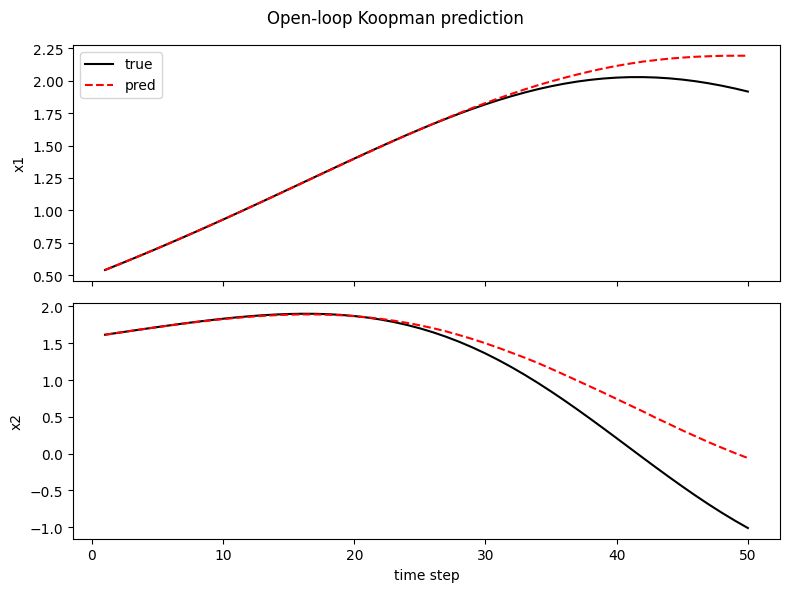

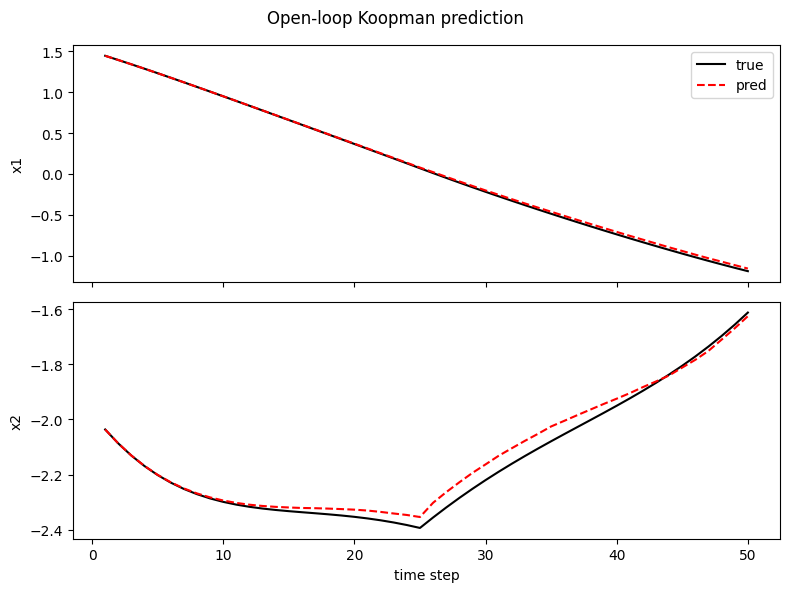

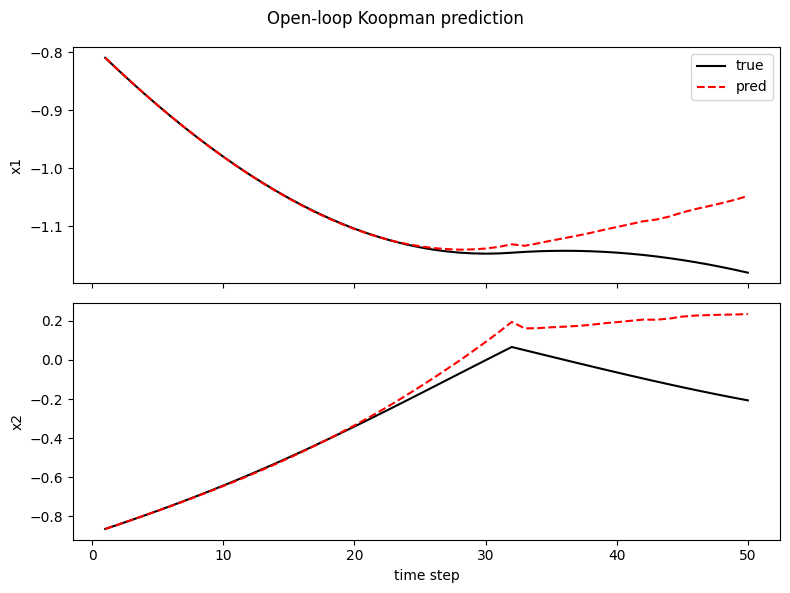

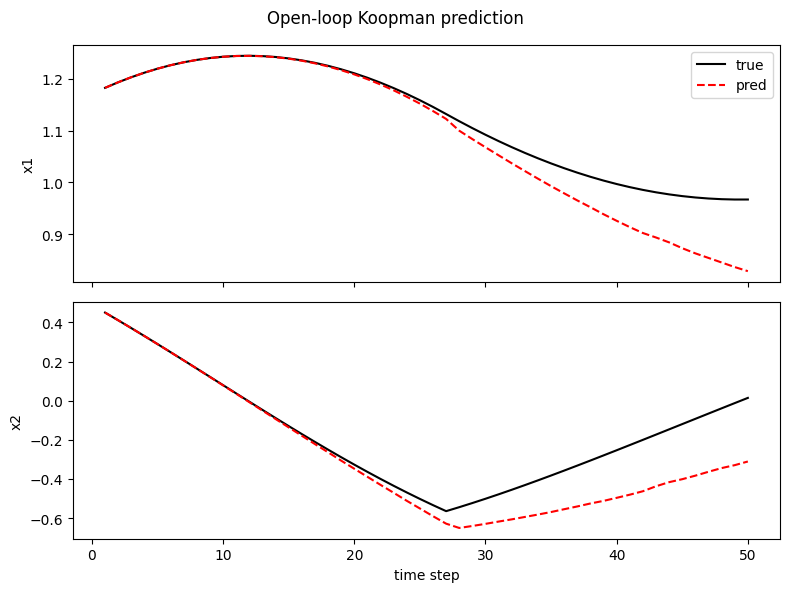

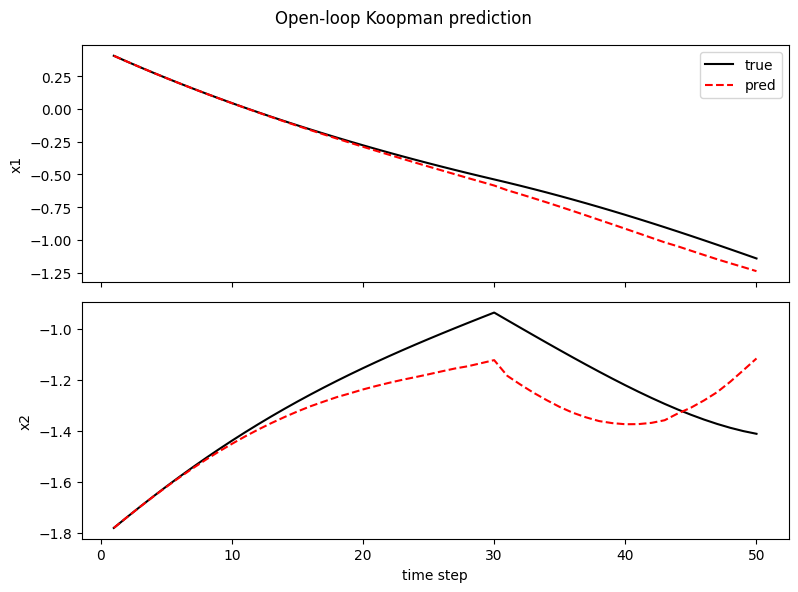

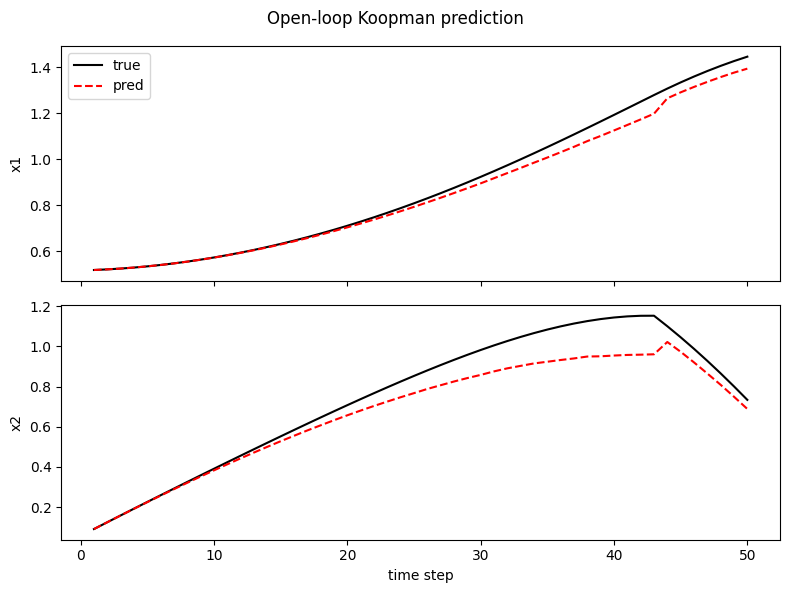

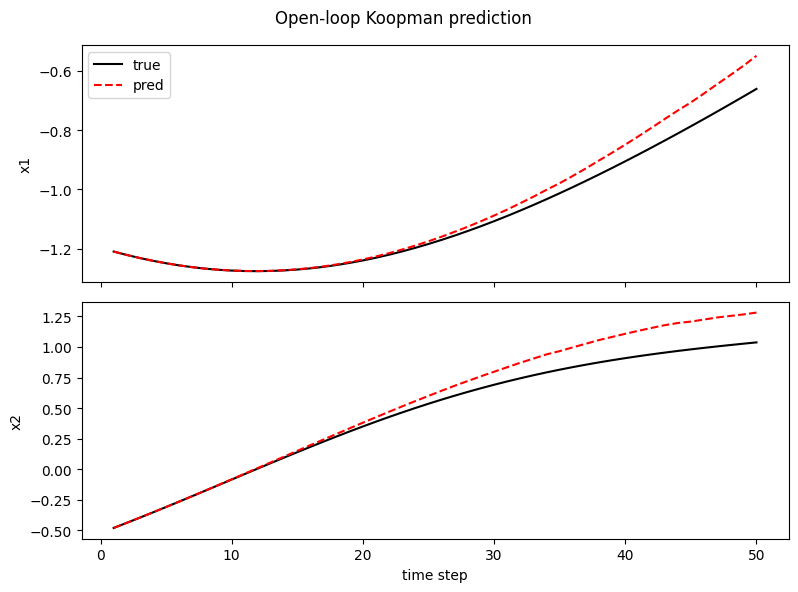

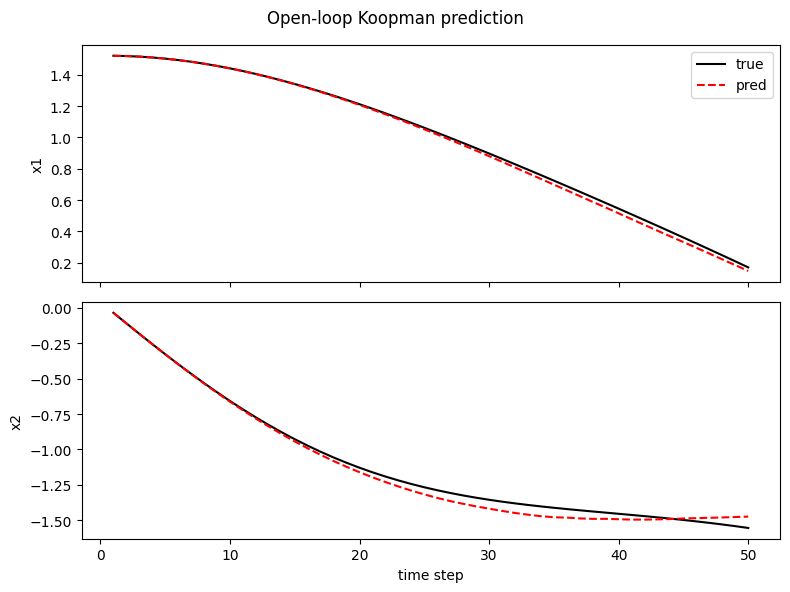

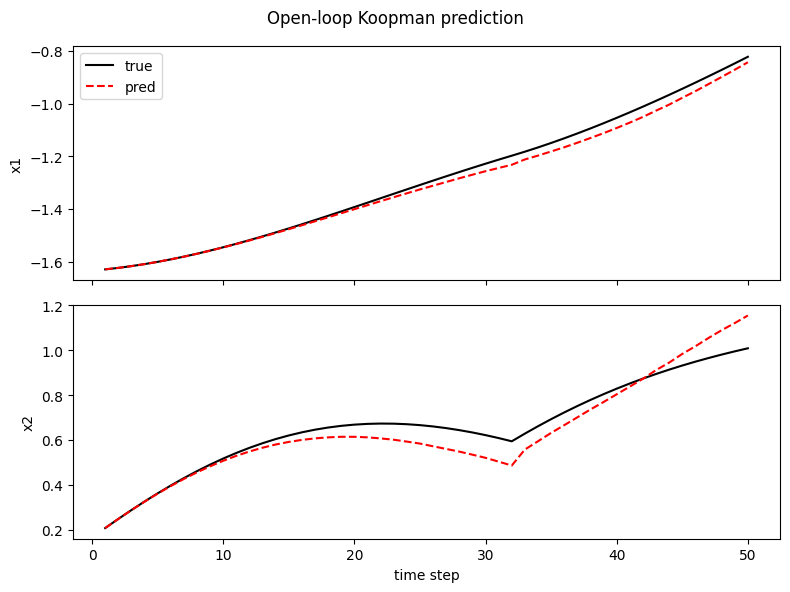

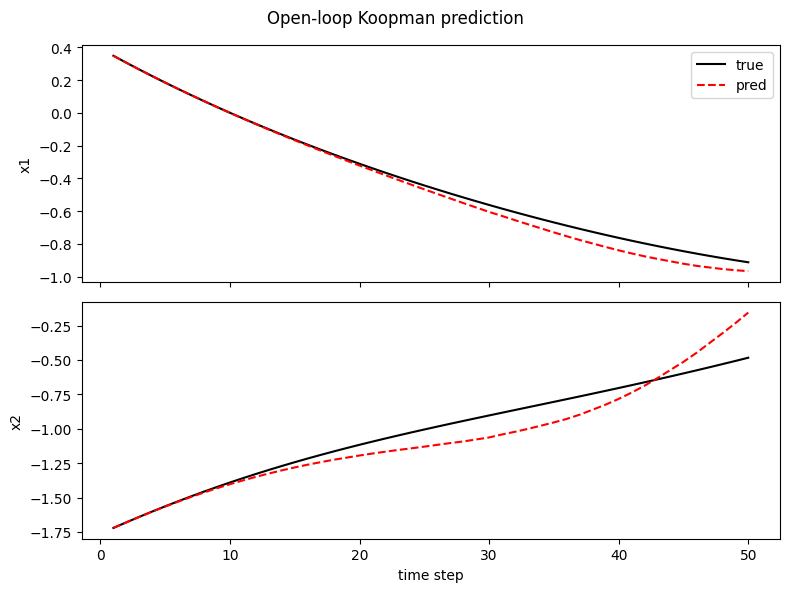

In [11]:
# Suppose state dim = 2, horizon N = 20, input dim = 1
n_x, N, m = 2, T_steps-1, 1
for i in range(10):
    psi_xt = Z[i,:].numpy()
    U_seq = U[i,:,:].reshape((N*m,))
    X_pred = open_loop_predict(E, F, psi_xt, U_seq, n_x, N)
    X_true = Yt[i,:,:].numpy()
    X_true = X_true.T
    # ground truth trajectory from dataset

    plot_trajectory(X_true, X_pred, title="Open-loop Koopman prediction")

In [23]:
error = np.zeros_like(X)
for i in range(Z.shape[0]):
    psi_xt = Z[i,:].numpy()
    U_seq = U[i,:,:].reshape((N*m,))
    X_pred = open_loop_predict(E, F, psi_xt, U_seq, n_x, N)
    X_true = Yt[i,:,:].numpy()
    error[i,:,:] = (X_true - X_pred.T)**2

print(error.mean(axis=(0, 1)))

#save error
np.savez_compressed("duffing_multistep_edmdc_mse.npz", mse_t_multistep = error.mean(axis=(0, 1)))

[4.02682693e-11 2.55488201e-09 2.88167146e-08 1.60126301e-07
 6.03297239e-07 1.77667120e-06 4.41172381e-06 9.66415907e-06
 1.92273684e-05 3.54404836e-05 6.12486460e-05 1.00414989e-04
 1.57848426e-04 2.38896205e-04 3.49525268e-04 4.96681707e-04
 6.86352471e-04 9.28042548e-04 1.22815890e-03 1.59561982e-03
 2.03923706e-03 2.56671356e-03 3.18733844e-03 3.90612306e-03
 4.73650658e-03 5.68065140e-03 6.75765427e-03 7.95774994e-03
 9.31625785e-03 1.08241619e-02 1.24902423e-02 1.43385961e-02
 1.63706996e-02 1.86064598e-02 2.10118050e-02 2.36368669e-02
 2.65149957e-02 2.96095671e-02 3.29097517e-02 3.65075164e-02
 4.03556224e-02 4.44508268e-02 4.86760702e-02 5.31781095e-02
 5.78995551e-02 6.29681244e-02 6.82402182e-02 7.37261893e-02
 7.93773896e-02 8.52237120e-02]


In [14]:
import cvxpy as cp
import numpy as np

def mpc_step(E, F, psi_xt, x_ref, Q, R, umin, umax, n_x, m, N):
    """
    One MPC optimization step.
    
    E: (N*n_x, p)
    F: (N*n_x, N*m)
    psi_xt: (p,) lifted state at current x_t
    x_ref: (N, n_x) reference trajectory
    Q: (n_x, n_x) state cost
    R: (m, m) input cost
    umin, umax: (m,) lower/upper bounds for inputs
    """
    # decision variable: stacked inputs over horizon
    U = cp.Variable(N*m)

    # predicted stacked states
    stacked = E @ psi_xt + F @ U   # shape (N*n_x,)
    X_pred = cp.reshape(stacked, (N, n_x))

    # cost
    cost = 0
    for k in range(N):
        cost += cp.quad_form(X_pred[k, :] - x_ref[k, :], Q)
        if k < N:
            u_k = U[k*m:(k+1)*m]
            cost += cp.quad_form(u_k, R)

    # constraints
    constraints = []
    for k in range(N):
        u_k = U[k*m:(k+1)*m]
        constraints += [umin <= u_k, u_k <= umax]

    # solve
    prob = cp.Problem(cp.Minimize(cost), constraints)
    prob.solve(solver=cp.OSQP, warm_start=True, verbose=False)

    if prob.status not in ["optimal", "optimal_inaccurate"]:
        print("MPC infeasible, status:", prob.status)
        return None

    # return only first control move
    u0 = U.value[:m]
    return u0, X_pred.value

In [15]:
# Example dims
n_x, m, N = 2, 1, T_steps-1
Ts       = 0.025
# current lifted state

# reference trajectory: e.g. zeros
x_ref = np.zeros((N, n_x))

# costs
Q = np.eye(n_x) * 1.0
R = np.eye(m) * 0.01

x0 = np.array([[1.0, 0.0]])  # initial state
# input constraints
umin = np.array([-1.0])
umax = np.array([ 1.0])
#store control actions and states
u_history = []
x_history = [x0.copy()]
for i in range(2000):
    x0t = torch.tensor(x0)
    psi_xt =  legendre2d_phi_box(x0t, box, deg_poly, include_bias=True, total_degree=True) 
    psi_xt = np.squeeze(psi_xt.numpy())
    u0, Xpred = mpc_step(E, F, psi_xt, x_ref, Q, R, umin, umax, n_x, m, N)
    x0 =  rk4_step(x0.flatten(), u0[0], Ts, delta, alpha, beta).reshape(1,-1)
    if i % 100 == 0:
        print("State",i,x0)
        print(u0)
    u_history.append(u0)
    x_history.append(x0.copy())

#save closed loop trajectory to npz file
np.savez_compressed("duffing_mpc_trajectory.npz", trajectory = x_history)
np.savez_compressed("duffing_mpc_u_history.npz", u_history = u_history)

State 0 [[ 0.99968805 -0.02493241]]
[-1.]
State 100 [[ 0.43987479 -0.12880833]]
[-0.31875011]
State 200 [[ 0.24450268 -0.04769418]]
[-0.22511054]
State 300 [[ 0.15562213 -0.02681636]]
[-0.15230992]
State 400 [[ 0.10135403 -0.01735132]]
[-0.10099761]
State 500 [[ 0.06612634 -0.01126923]]
[-0.06628601]
State 600 [[ 0.04324379 -0.00732101]]
[-0.04345576]
State 700 [[ 0.02837711 -0.00475677]]
[-0.02854493]
State 800 [[ 0.01871717 -0.00309094]]
[-0.01883465]
State 900 [[ 0.01243999 -0.0020086 ]]
[-0.01251872]
State 1000 [[ 0.00836081 -0.00130529]]
[-0.00841266]
State 1100 [[ 0.00570992 -0.00084827]]
[-0.00574381]
State 1200 [[ 0.00398718 -0.00055127]]
[-0.00400926]
State 1300 [[ 0.00286761 -0.00035826]]
[-0.00288198]
State 1400 [[ 0.00214002 -0.00023283]]
[-0.00214937]
State 1500 [[ 0.00166717 -0.00015131]]
[-0.00167325]
State 1600 [[ 1.35987724e-03 -9.83341467e-05]]
[-0.00136383]
State 1700 [[ 1.16016884e-03 -6.39061525e-05]]
[-0.00116274]
State 1800 [[ 1.03038075e-03 -4.15318602e-05]]
[-0

(100, 13)
13


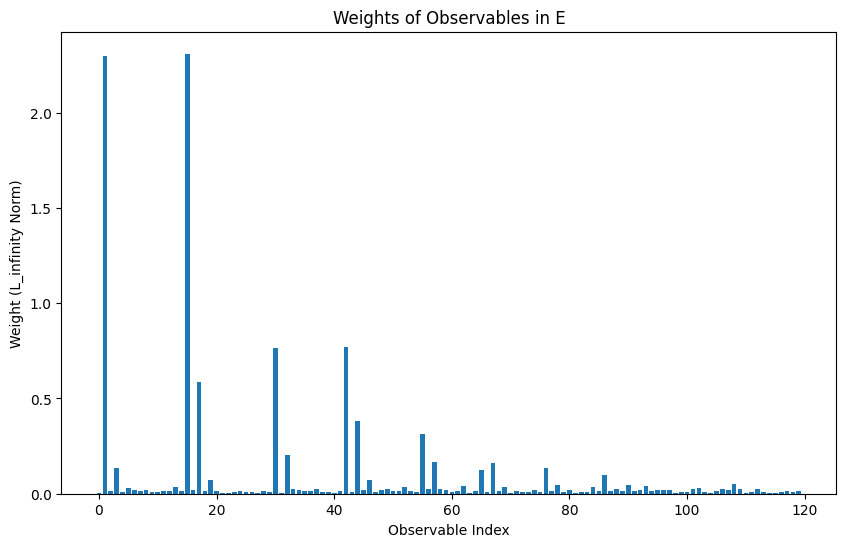

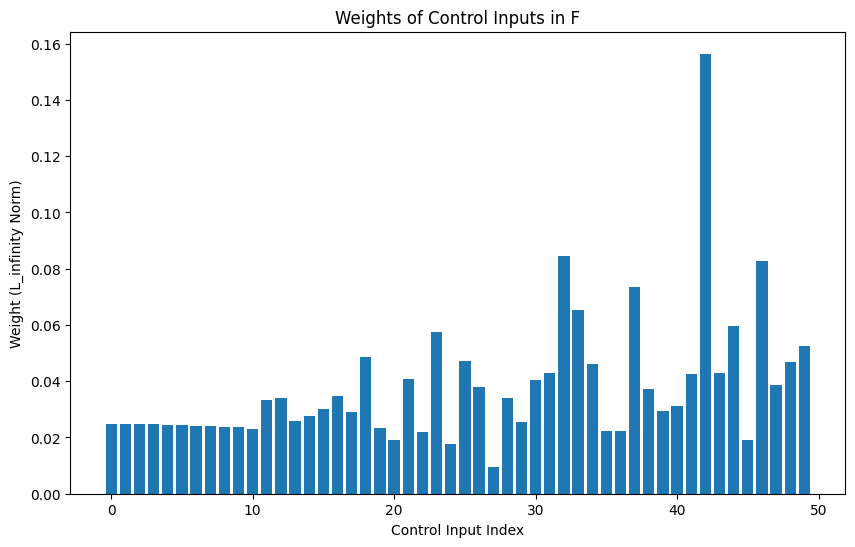

In [16]:
def prune(E,eps_E):
    idx = []
    for i in range(E.shape[1]):
        if np.linalg.norm(E[:,i],ord =float('inf')) > eps_E:
            idx.append(i)
    E_pruned = E[:,idx]

    return E_pruned, idx

E_pruned, idx = prune(E,1e-1)
print(E_pruned.shape)
print(len(idx))


def plot_obsevable_weights(E):
    """
    Plot the weights of the observables in E.
    """

    num_observables = E.shape[1]
    weights = np.linalg.norm(E, ord = float('inf'), axis=0)

    plt.figure(figsize=(10, 6))
    plt.bar(range(num_observables), weights)
    plt.xlabel('Observable Index')
    plt.ylabel('Weight (L_infinity Norm)')
    plt.title('Weights of Observables in E')
    plt.show()

plot_obsevable_weights(E)


def plot_control_weights(F):
    """
    Plot the weights of the control inputs in F.
    """

    num_controls = F.shape[1]
    weights = np.linalg.norm(F, ord = float('inf'), axis=0)

    plt.figure(figsize=(10, 6))
    plt.bar(range(num_controls), weights)
    plt.xlabel('Control Input Index')
    plt.ylabel('Weight (L_infinity Norm)')
    plt.title('Weights of Control Inputs in F')
    plt.show()
plot_control_weights(F)
def prune_observables(psi_xt, idx):
    """
    Prune the observables in psi_xt based on the indices in idx.
    """
    return psi_xt[idx]


x0 = np.array([[2.0,1.0]])
x0t = torch.tensor(x0)
psi_xt =  legendre2d_phi_box(x0t, box, deg_poly, include_bias=True, total_degree=True) 
psi_xt = np.squeeze(psi_xt.numpy())
psi_xt_pruned = prune_observables(psi_xt, idx)

In [17]:
#compute open loop error for pruned model
error_pruned = np.zeros_like(X)
for i in range(Z.shape[0]):
    psi_xt = Z[i,:].numpy()
    psi_xt_pruned = prune_observables(psi_xt, idx)
    U_seq = U[i,:,:].reshape((N*m,))
    X_pred = open_loop_predict(E_pruned, F, psi_xt_pruned, U_seq, n_x, N)
    X_true = Yt[i,:,:].numpy()
    error_pruned[i,:,:] = (X_true - X_pred.T)**2

print(error_pruned.mean(axis=(0, 1)))
## save
np.savez_compressed("duffing_multistep_edmdc_pruned_mse.npz", mse_t_multistep_pruned = error_pruned.mean(axis=(0, 1)))

[4.37362586e-11 2.77778791e-09 3.13656622e-08 1.74490866e-07
 6.58181973e-07 1.94051877e-06 4.82386108e-06 1.05777981e-05
 2.10647349e-05 3.88592070e-05 6.71850561e-05 1.10429031e-04
 1.73659347e-04 2.62898506e-04 3.84908141e-04 5.47066652e-04
 7.56861129e-04 1.02333325e-03 1.35302994e-03 1.75724123e-03
 2.24429926e-03 2.82238121e-03 3.50078263e-03 4.28292305e-03
 5.18499285e-03 6.20725211e-03 7.37114738e-03 8.66732816e-03
 1.01287708e-02 1.17447415e-02 1.35246593e-02 1.54966264e-02
 1.76523713e-02 2.00343241e-02 2.25937019e-02 2.53981087e-02
 2.84590229e-02 3.17784674e-02 3.52871441e-02 3.91186992e-02
 4.32268999e-02 4.75961613e-02 5.21039124e-02 5.69290533e-02
 6.19647445e-02 6.73862955e-02 7.30173638e-02 7.88608521e-02
 8.48646176e-02 9.11027218e-02]


In [18]:

u_history = []
x0 = np.array([[1.0, 0.0]])  # initial state
x_history = [x0.copy()]

for i in range(2000):
    x0t = torch.tensor(x0)
    psi_xt =  legendre2d_phi_box(x0t, box, deg_poly, include_bias=True, total_degree=True) 
    psi_xt = np.squeeze(psi_xt.numpy())
    psi_xt_pruned = prune_observables(psi_xt, idx)
    u0, Xpred = mpc_step(E_pruned, F, psi_xt_pruned, x_ref, Q, R, umin, umax, n_x, m, N)
    x0 = np.array([rk4_step(x0[0], u0[0], Ts, delta, alpha, beta)]).reshape(1,-1)
    if i % 100 == 0:
        print("State",i,x0)
        print(u0)
    u_history.append(u0)
    x_history.append(x0.copy())

#save closed loop trajectory to npz file
np.savez_compressed("duffing_mpc_trajectory_pruned.npz", trajectory = x_history)
np.savez_compressed("duffing_mpc_u_history_pruned.npz", u_history = u_history)




State 0 [[ 0.99968805 -0.02493241]]
[-1.]
State 100 [[ 0.43457702 -0.12975418]]
[-0.31515071]
State 200 [[ 0.23939899 -0.04732954]]
[-0.22129739]
State 300 [[ 0.15140185 -0.02651591]]
[-0.14854801]
State 400 [[ 0.09783627 -0.01708291]]
[-0.09754158]
State 500 [[ 0.06323225 -0.01104017]]
[-0.06339685]
State 600 [[ 0.04086812 -0.00713529]]
[-0.04107036]
State 700 [[ 0.02641397 -0.00461165]]
[-0.02657056]
State 800 [[ 0.01707198 -0.00298061]]
[-0.01718018]
State 900 [[ 0.01103405 -0.00192644]]
[-0.01110586]
State 1000 [[ 0.00713158 -0.0012451 ]]
[-0.00717851]
State 1100 [[ 0.00460932 -0.00080474]]
[-0.00463979]
State 1200 [[ 0.00297912 -0.00052012]]
[-0.00299885]
State 1300 [[ 0.00192548 -0.00033617]]
[-0.00193824]
State 1400 [[ 0.00124449 -0.00021728]]
[-0.00125274]
State 1500 [[ 0.00080434 -0.00014043]]
[-0.00080968]
State 1600 [[ 5.19867958e-04 -9.07637556e-05]]
[-0.00052332]
State 1700 [[ 3.36003859e-04 -5.86629193e-05]]
[-0.00033823]
State 1800 [[ 2.17167824e-04 -3.79153340e-05]]
[-0

In [19]:
#compare with single-step EDMD
n_x, m, N = 2, 1, T_steps-1
def edmdc(X, Y, U, psi, lam=0.0):
    """One-step EDMDc (Koopman with control)
    X, Y: (N × n_x)
    U: (N × m)
    psi: lifting function ψ(x) → ℝ^p
    lam: ridge regularization
    Returns A, B such that ψ(x_{t+1}) ≈ A ψ(x_t) + B u_t
    """
    Psi_X = psi(X)
    Psi_Y = psi(Y)
    H = np.hstack([Psi_X, U])
    G = H.T @ H + lam * np.eye(H.shape[1])
    AB = np.linalg.solve(G, H.T @ Psi_Y)
    p = Psi_X.shape[1]
    A = AB[:p, :]
    B = AB[p:, :]
    return A, B

print(X.shape, Y.shape, U.shape)
X_flat = X[:, :, 0].reshape(-1, n_x)   # all x_t
Y_flat = Y[:, :, 0].reshape(-1, n_x)   # all x_{t+1}
U_flat = U[:, :, 0].reshape(-1, m)     # all u_t
print(X_flat.shape, Y_flat.shape, U_flat.shape)

psi = lambda x: legendre2d_phi_box(torch.tensor(x), box, deg_poly,
                                   include_bias=True, total_degree=True).numpy()

A_edmd, B_edmd = edmdc(X_flat, Y_flat, U_flat, psi, lam=1e-3)


print("A shape:", A_edmd.shape)
print("SpectralRadius of A: ", max(abs(np.linalg.eigvals(A_edmd))))
print("B shape:", B_edmd.shape)

(2000, 2, 50) (2000, 2, 50) (2000, 1, 50)
(2000, 2) (2000, 2) (2000, 1)
A shape: (120, 120)
SpectralRadius of A:  2.5538298583483154
B shape: (1, 120)


In [20]:
# --- EDMDc rollout using your decoder ---
def open_loop_rollout_edmdc_decoded(A, B, psi, x0, U_seq, pairs, box, include_bias=True):
    """
    ψ_{t+1} = ψ_t A + u_t B, then decode ψ_{t+1} → x_{t+1} via decode_legendre2d
    x0: (1, n_x), U_seq: (H, m)
    returns X_pred: (H, n_x)
    """
    x = x0.copy()
    traj = []
    for k in range(U_seq.shape[0]):
        psi_x   = psi(x)                           # (1, p) numpy
        psi_nxt = psi_x @ A + U_seq[k:k+1] @ B  # (1, p) numpy
        # decode using your function (expects torch tensors)
        Z_torch = torch.tensor(psi_nxt)            # (1, p)
        _, X_hat = decode_legendre2d(Z_torch, pairs, box, include_bias=include_bias)
        x = X_hat.cpu().numpy()                    # (1, n_x)
        traj.append(x.squeeze())
    return np.vstack(traj)


def edmdc_mse_timewise_decoded(A, B, psi, X, Y, U, pairs, box, N_max = 10000000000, include_bias=True):
    Ntraj, n_x, H = X.shape
    Y_pred_all = np.zeros_like(Y[0:min(Ntraj,N_max)])
    for i in range(min(Ntraj,N_max)):
        x0    = X[i, :, 0:1].T        # (1, n_x)
        U_seq = U[i].T                # (H, m)
        Y_pred = open_loop_rollout_edmdc_decoded(A, B, psi, x0, U_seq, pairs, box, include_bias)
        Y_pred_all[i] = Y_pred.T
    err = (Y[0:min(Ntraj,N_max)]  - Y_pred_all)**2
    return err.mean(axis=(0, 1))

# usage
mse_t_edmdc  = edmdc_mse_timewise_decoded(A_edmd, B_edmd, psi, X, Y, U, pairs, box, N_max = 1000, include_bias=True)
print("Per-step MSE:", mse_t_edmdc)
np.savez_compressed("duffing_edmdc_mse.npz", mse_t_edmdc = mse_t_edmdc)

C:\Users\TGY\AppData\Local\Temp\ipykernel_39072\1034269130.py:12: RuntimeWarning: invalid value encountered in matmul
  psi_nxt = psi_x @ A + U_seq[k:k+1] @ B  # (1, p) numpy


Per-step MSE: [4.74061023e-11 2.07099030e-10 1.10767459e-09 1.11199777e-08
 9.04505899e-08 5.07500867e-07 2.05250175e-06 6.39452295e-06
 1.67521634e-05 4.16732992e-05 1.21983161e-04 8.22687581e-04
 9.80928731e-01 4.37716278e+30            inf            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan]


C:\Users\TGY\AppData\Local\Temp\ipykernel_39072\1034269130.py:29: RuntimeWarning: overflow encountered in square
  err = (Y[0:min(Ntraj,N_max)]  - Y_pred_all)**2


In [21]:
#construct E and F
import numpy as np

def construct_E_F_decoded_lastNx(A: np.ndarray, B: np.ndarray, H: int, Nx: int):
    """
    Dynamics (row-vector convention):
      psi_{t+1} = psi_t @ A + u_t @ B
    Decode:
      x_t = last Nx entries of psi_t  =>  x_t = psi_t @ C.T  with C selecting last Nx coords

    A: (p, p)
    B: (m, p)   <-- IMPORTANT (matches your rollout)
    Returns:
      E: (Nx*H, p)
      F: (Nx*H, m*H)
    """
    p = A.shape[0]
    m = B.shape[0]
    assert A.shape == (p, p)
    assert B.shape[1] == p
    assert Nx <= p

    # C selects last Nx coordinates
    C = np.hstack([np.zeros((Nx, p - Nx)), np.eye(Nx)])  # (Nx, p)

    # Precompute A^0..A^(H-1)
    A_pows = [np.eye(p)]
    for _ in range(1, H):
        A_pows.append(A_pows[-1] @ A)

    # E = [C A; C A^2; ...; C A^H]
    E_blocks = []
    A_pow = A.copy()  # A^1
    for _ in range(1, H + 1):
        E_blocks.append(C @ A_pow)  # (Nx, p)
        A_pow = A_pow @ A
    E = np.vstack(E_blocks)         # (Nx*H, p)

    # F: lower-triangular with blocks C A^(i-j) B^T
    zero = np.zeros((Nx, m))
    F_rows = []
    Bt = B.T  # (p, m)
    for i in range(H):
        row_blocks = []
        for j in range(H):
            if i >= j:
                k = i - j
                row_blocks.append(C @ A_pows[k] @ Bt)  # (Nx, m)
            else:
                row_blocks.append(zero)
        F_rows.append(row_blocks)
    F = np.block(F_rows)  # (Nx*H, m*H)

    return E, F

print("T_steps", T_steps)
E_single, F_single = construct_E_F_decoded_lastNx(A_edmd, B_edmd, H=10, Nx=2)
print(E_single.shape)  # should be ((Nx*(T_steps-1), p)
print(F_single.shape)  # should be ((Nx*(T_steps-1), (n_u*(T_steps-1)))
print("E_single:", E_single)
print("F_single:", F_single)

T_steps 51
(20, 120)
(20, 10)
E_single: [[-4.33272416e-09 -2.69116407e-07 -1.89159626e-03 ...  8.46799702e-04
   9.60413898e-01  3.96600528e-01]
 [-4.81510357e-08 -9.45260230e-08  3.39241966e-04 ... -7.86423067e-05
  -4.48432687e-02  9.87335622e-01]
 [-4.88505005e-09 -2.46757062e-06 -4.17050327e-03 ...  6.63510614e-03
   8.62249629e-01  7.58333760e-01]
 ...
 [-7.36477050e-05  2.28010251e-03 -8.73590975e-01 ...  2.61201268e-01
  -9.29489301e-01  8.27023660e-03]
 [ 2.91508480e-04 -9.94919985e-03  3.58599397e+00 ...  1.60467242e+00
   3.38728215e+00  3.75655689e+00]
 [-1.89649121e-04  6.15868119e-03 -2.29956525e+00 ...  1.83297182e-01
  -2.26787198e+00 -8.68319309e-01]]
F_single: [[-4.30268444e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-3.77952430e-05  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+

In [22]:

u_history = []
x0 = np.array([[1.0, 0.0]])  # initial state
x_history = [x0.copy()]
N_p = 10

for i in range(2000):
    x0t = torch.tensor(x0)
    psi_xt =  legendre2d_phi_box(x0t, box, deg_poly, include_bias=True, total_degree=True) 
    psi_xt = np.squeeze(psi_xt.numpy())
    u0, Xpred = mpc_step(E_single, F_single, psi_xt, x_ref, Q, R, umin, umax, n_x, m, N_p)
    x0 =  rk4_step(x0.flatten(), u0[0], Ts, delta, alpha, beta).reshape(1,-1)
    if i % 100 == 0:
        print("State",i,x0)
        print(u0)
    u_history.append(u0)
    x_history.append(x0.copy())

#save closed loop trajectory to npz file
np.savez_compressed("duffing_single_step_mpc_trajectory.npz", trajectory = x_history)
np.savez_compressed("duffing_single_step_mpc_u_history.npz", u_history = u_history)


State 0 [[ 0.99968805 -0.02493241]]
[-1.]
State 100 [[ 0.96569295 -0.02587448]]
[-1.]
State 200 [[ 0.91719099 -0.03663046]]
[-1.]
State 300 [[ 0.85233612 -0.01018291]]
[1.]
State 400 [[ 0.76810081 -0.03914715]]
[-1.]
State 500 [[ 0.65919006 -0.05459373]]
[-1.]
State 600 [[ 0.50680313 -0.08874926]]
[-0.8920374]
State 700 [[ 0.29795104 -0.0970825 ]]
[-1.]
State 800 [[ 0.01229218 -0.14665513]]
[-1.]
State 900 [[-0.39049762 -0.18086843]]
[1.]
State 1000 [[-0.93950635 -0.2613865 ]]
[-1.]
State 1100 [[-1.41978319  0.14901507]]
[-1.]
State 1200 [[0.20311644 0.77572972]]
[1.]
State 1300 [[ 1.31006017 -0.90961976]]
[1.]
State 1400 [[-1.12885107 -1.06990125]]
[0.71876208]
State 1500 [[-0.47874837  0.69649335]]
[1.]
State 1600 [[1.48251622 0.75933211]]
[1.]
State 1700 [[-0.12988246 -1.01857791]]
[-0.63606178]
State 1800 [[-1.12047822  0.82652591]]
[-1.]
State 1900 [[0.68320077 0.82582625]]
[0.53647534]
